In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
file = open("temp_model.pickle",'rb')
df = pickle.load(file)
df.head()

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE


In [3]:
df.dtypes

DWG Number          object
RLocation           object
Tag                 object
Area               float64
Type                object
Loop Number        float64
Location           float64
Description         object
Manufacturer       float64
Model Number       float64
Comment            float64
Class Name          object
PnPID                int64
Area No            float64
Unit No            float64
Supplied By         object
Status              object
Sequence Number    float64
Suffix              object
Instrument Spec    float64
Spec Issued        float64
PO Issued          float64
Signal Type 1       object
Signal Type 2       object
Signal Type 3       object
dtype: object

In [4]:
lats = []
lons = []

for row in df['RLocation']:
    if type(row) != str:
        lat,lon = (None,None)
    else:
        lat,lon = tuple(str(row).split(','))
        lat = int(lat)
        lon = int(lon)
    lats.append(lat)
    lons.append(lon)
df["Lat"] = lats
df["Long"] = lons 

In [5]:
df['RLocation'].notna().head(20)

0      True
1      True
2     False
3      True
4     False
5      True
6      True
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17    False
18     True
19    False
Name: RLocation, dtype: bool

In [6]:
df_located = df[['RLocation','Lat','Long']][df['RLocation'].notna()]

In [7]:
df_located.describe()

,Lat,Long
count,97.000000,97.000000
mean,376.824742,292.587629
std,150.514673,190.005688
min,266.000000,83.000000
25%,294.000000,117.000000
50%,300.000000,158.000000
75%,535.000000,557.000000
max,774.000000,564.000000


In [8]:
X = np.array(df_located)
X = X[:,1:3]

In [9]:
X[:20]

array([[298.0, 561.0],
       [300.0, 561.0],
       [299.0, 562.0],
       [300.0, 561.0],
       [301.0, 562.0],
       [302.0, 563.0],
       [301.0, 564.0],
       [301.0, 564.0],
       [299.0, 563.0],
       [771.0, 289.0],
       [771.0, 291.0],
       [773.0, 292.0],
       [774.0, 293.0],
       [774.0, 292.0],
       [773.0, 292.0],
       [773.0, 292.0],
       [534.0, 315.0],
       [537.0, 318.0],
       [536.0, 316.0],
       [535.0, 318.0]], dtype=object)

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [11]:
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
# Higher min_samples or lower eps indicate higher density necessary to form a cluster.
db = DBSCAN(eps=0.03, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 7
Estimated number of noise points: 0


<Figure size 640x480 with 1 Axes>

In [12]:
db.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### With the small adjust ment in eps(cluster radius) and min_sample(minimum cluster size) we were a ble to group locations into clusters that represent unit. This allow us to bin the locations into each unit.

In [13]:
df_located["unit_label"] = db.labels_

In [14]:
df_located.index

Int64Index([  0,   1,   3,   5,   6,   8,  16,  18,  21,  27,  28,  29,  31,
             32,  33,  38,  44,  45,  46,  47,  51,  54,  55,  61,  62,  63,
             64,  65,  66,  79,  81,  83,  84,  85,  92,  96, 100, 101, 102,
            103, 104, 105, 118, 122, 123, 124, 135, 136, 137, 141, 142, 155,
            173, 176, 177, 179, 189, 197, 198, 199, 200, 202, 203, 206, 208,
            209, 210, 236, 237, 240, 241, 242, 243, 266, 267, 268, 269, 271,
            279, 287, 291, 295, 297, 299, 300, 303, 304, 307, 308, 309, 322,
            324, 325, 326, 328, 332, 337],
           dtype='int64')

In [15]:
df["unit_label"] = None
df.iloc[df_located.index, -1] = db.labels_

In [16]:
pd.set_option('display.max_rows',100)
df.iloc[:,[0,1,-1]][df["RLocation"].notna()]

,DWG Number,RLocation,unit_label
0,PID-143,"298,561",0
1,PID-143,"300,561",0
3,PID-143,"299,562",0
5,PID-143,"300,561",0
6,PID-143,"301,562",0
8,PID-143,"302,563",0
16,PID-143,"301,564",0
18,PID-143,"301,564",0
21,PID-143,"299,563",0
27,PID-101,"771,289",1


#### We can now use unit_label enumeration as a target variable. This effectively bined the locations into categorical variables. We can use these labeled location now as training set for the machine learning algorithm to classify each intrument tags into the location. In this data set, this will be trivial since P&ID number is tied directly 1 to 1 with the location. None the less, we can mix other attributes in and provide a general framework for predicting the location of the instrument tag.

In [17]:
groupby_unit_label_Lat = df[df['Lat'].notnull()].groupby('unit_label').mean()[['Lat','Long']]

In [18]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat':'Lat_mean','Long':'Long_mean'})

In [19]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'unit_label')

In [20]:
df_encoded = pd.get_dummies(df[['DWG Number','Type','Description','Suffix','Signal Type 1']], prefix=['DWG','Type','Description','Suffix','Signal Type 1'])

In [21]:
df.iloc[:,15:]

,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
2,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
3,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
4,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,With assembly,NaN,3.0,G,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
348,With assembly,NaN,5.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
349,NaN,NaN,4.0,E,NaN,NaN,NaN,DIASI,DIASI,NONE,NaN,NaN,None,NaN,NaN
350,With assembly,NaN,3.0,J,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [22]:
df_numeric = df[['Area No','Unit No','Sequence Number']]
df_numeric

,Area No,Unit No,Sequence Number
0,20.0,77.0,53.0
1,20.0,41.0,1.0
2,20.0,41.0,1.0
3,20.0,41.0,2.0
4,20.0,41.0,1.0
...,...,...,...
347,20.0,41.0,3.0
348,20.0,41.0,5.0
349,20.0,41.0,4.0
350,20.0,41.0,3.0


In [23]:
normalized_df = df_encoded.merge(df_numeric,left_index=True, right_index=True)

In [24]:
normalized_df.iloc[:,-40:].head()

,DWG_PID-132,DWG_PID-133,DWG_PID-141,DWG_PID-142,DWG_PID-143,Type_X1FV,Type_XPL,Type_XY,Type_ZIS,Type_ZSC,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,20.0,77.0,53.0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,20.0,41.0,1.0
3,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,20.0,41.0,2.0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0


In [25]:
train_index = normalized_df[df["RLocation"].notna()].dropna().index

In [26]:
df

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,PID-142,NaN,20-ZSC-4103G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
348,PID-142,NaN,20-ZIS-4105K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
349,PID-142,NaN,20-ZSC/O-4104E,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,...,NaN,NaN,DIASI,DIASI,NONE,NaN,NaN,None,NaN,NaN
350,PID-142,NaN,20-ZIS-4103J,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [27]:
df.iloc[train_index,:]

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
5,PID-143,"300,561",20-XY-4102E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
6,PID-143,"301,562",20-XY-4101B,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,301.0,562.0,0,298.481481,561.222222
8,PID-143,"302,563",20-ZSC-4101C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,302.0,563.0,0,298.481481,561.222222
16,PID-143,"301,564",20-ZSC-4102G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,301.0,564.0,0,298.481481,561.222222
18,PID-143,"301,564",20-ZSC/O-4101F,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,...,NaN,NaN,DIASI,DIASI,NONE,301.0,564.0,0,298.481481,561.222222
21,PID-143,"299,563",20-XY-4102A,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,299.0,563.0,0,298.481481,561.222222
27,PID-101,"771,289",20-XY-0101P,NaN,XY,NaN,NaN,4-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,771.0,289.0,1,772.714286,291.571429


In [28]:
X = np.array(normalized_df[df["RLocation"].notna()].dropna())
y = np.array(pd.get_dummies(df.iloc[train_index,:]["unit_label"]))
print(X.shape)
print(y.shape)

(96, 48)
(96, 7)


In [29]:
X[30]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1., 20., 11.,  2.])

In [30]:
y

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0,

In [31]:
from sklearn.neighbors import KNeighborsClassifier
model_knn= KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
test_index = normalized_df[df["RLocation"].isna()].dropna().index

In [33]:
normalized_df.iloc[test_index,:]

,DWG_PID-101,DWG_PID-102,DWG_PID-103,DWG_PID-111,DWG_PID-121,DWG_PID-122,DWG_PID-123,DWG_PID-131,DWG_PID-132,DWG_PID-133,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,2.0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,2.0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,3.0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,5.0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,4.0
350,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,20.0,41.0,3.0


In [34]:
X_test = np.array(normalized_df.iloc[test_index,:])

In [35]:
y_pred = model_knn.predict(X_test)

In [36]:
y_pred.shape

(249, 7)

#### Below is a experimental attempt to use Matrix Factorization to reconstruct the missing unit information in the full dataset

In [45]:
from sklearn import preprocessing

#### Save index of the full dataset without NA

In [73]:
full_index = normalized_df.dropna().index

In [74]:
full_index.shape

(345,)

In [100]:
label_arr = np.array([df.iloc[full_index,:]["unit_label"]])

In [102]:
label_arr = np.reshape(label_arr,(label_arr.shape[1],1))

In [103]:
label_arr

array([[0],
       [0],
       [None],
       [0],
       [None],
       [0],
       [0],
       [None],
       [0],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [0],
       [None],
       [0],
       [None],
       [None],
       [0],
       [None],
       [None],
       [None],
       [None],
       [None],
       [1],
       [1],
       [1],
       [None],
       [1],
       [1],
       [1],
       [None],
       [None],
       [None],
       [None],
       [1],
       [None],
       [None],
       [None],
       [None],
       [None],
       [2],
       [2],
       [2],
       [2],
       [None],
       [None],
       [None],
       [2],
       [None],
       [None],
       [2],
       [2],
       [None],
       [None],
       [None],
       [None],
       [None],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [None],
       [None],
       [None],
       [None],
       [None],
       

In [61]:
normalized_df.iloc[0,:]

DWG_PID-101                                               0.0
DWG_PID-102                                               0.0
DWG_PID-103                                               0.0
DWG_PID-111                                               0.0
DWG_PID-121                                               0.0
DWG_PID-122                                               0.0
DWG_PID-123                                               0.0
DWG_PID-131                                               0.0
DWG_PID-132                                               0.0
DWG_PID-133                                               0.0
DWG_PID-141                                               0.0
DWG_PID-142                                               0.0
DWG_PID-143                                               1.0
Type_X1FV                                                 0.0
Type_XPL                                                  0.0
Type_XY                                                   0.0
Type_ZIS

In [92]:
normalized_df.iloc[full_index,:]

,DWG_PID-101,DWG_PID-102,DWG_PID-103,DWG_PID-111,DWG_PID-121,DWG_PID-122,DWG_PID-123,DWG_PID-131,DWG_PID-132,DWG_PID-133,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,77.0,53.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,3.0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,5.0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,4.0
350,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,20.0,41.0,3.0


In [151]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(normalized_df.iloc[full_index,:])
X_full = min_max_scaler.transform(normalized_df.iloc[full_index,:])

In [152]:
X_full.shape

(345, 48)

In [153]:
label_arr.shape

(345, 1)

In [154]:
X_full = np.hstack([X_full,label_arr])

In [155]:
X_full.shape

(345, 49)

In [156]:
GradientDescent_Flag_Mat = (X_full == None)

In [163]:
def matrix_factorization(R, P, Q, K,Flag_Mat, steps=5000, alpha=0.0002, beta=0.02):
    
    ### R = The user x item rating matrix (m x n)
    ### P = Initial user-factor matrix (m x k)
    ### Q = Initial item-factor matrix (n x k)
    ### K = The number of latent factors (features)
    ### steps = The number of epochs in gradient descent
    ### alpha = The learning rate for gradient descent
    ### beta = The regularization coefficient
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        ### update P and Q based on the partial derivatives
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        print("Step %d of %d; Error: %0.5f; Time: %0.2f" %(step+1, steps, e, time()))
    return P, Q.T

In [164]:
#Ratings = np.array(pd.DataFrame(X_full).fillna(0))
Ratings = np.array(X_full)

In [165]:
M = X_full.shape[0]
N = X_full.shape[1]
K = 5
steps = 3000

In [166]:
### Initialize P and Q to random values
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

In [ ]:
from time import time
t0 = time()
fP, fQ = matrix_factorization(Ratings, P, Q, K, GradientDescent_Flag_Mat, steps=steps)
print("done in %0.3fs." % (time() - t0))

Step 1 of 3000; Error: 18527.37068; Time: 1583034010.36
Step 2 of 3000; Error: 13510.28066; Time: 1583034011.07
Step 3 of 3000; Error: 10199.56708; Time: 1583034011.74
Step 4 of 3000; Error: 7958.79866; Time: 1583034012.51
Step 5 of 3000; Error: 6413.69662; Time: 1583034013.19
Step 6 of 3000; Error: 5333.14658; Time: 1583034013.84
Step 7 of 3000; Error: 4569.00137; Time: 1583034014.60
Step 8 of 3000; Error: 4023.54610; Time: 1583034015.25
Step 9 of 3000; Error: 3630.91535; Time: 1583034015.99
Step 10 of 3000; Error: 3345.97606; Time: 1583034016.72
Step 11 of 3000; Error: 3137.41518; Time: 1583034017.41
Step 12 of 3000; Error: 2983.30325; Time: 1583034018.07
Step 13 of 3000; Error: 2868.17299; Time: 1583034018.74
Step 14 of 3000; Error: 2781.05583; Time: 1583034019.43
Step 15 of 3000; Error: 2714.14092; Time: 1583034020.10
Step 16 of 3000; Error: 2661.84777; Time: 1583034020.80
Step 17 of 3000; Error: 2620.17882; Time: 1583034021.49
Step 18 of 3000; Error: 2586.26395; Time: 1583034022.2

Step 147 of 3000; Error: 1828.76839; Time: 1583034108.74
Step 148 of 3000; Error: 1826.60752; Time: 1583034109.40
Step 149 of 3000; Error: 1824.46751; Time: 1583034110.09
Step 150 of 3000; Error: 1822.34810; Time: 1583034110.66
Step 151 of 3000; Error: 1820.24905; Time: 1583034111.38
Step 152 of 3000; Error: 1818.17010; Time: 1583034112.08
Step 153 of 3000; Error: 1816.11101; Time: 1583034112.77
Step 154 of 3000; Error: 1814.07154; Time: 1583034113.47
Step 155 of 3000; Error: 1812.05147; Time: 1583034114.13
Step 156 of 3000; Error: 1810.05055; Time: 1583034114.82
Step 157 of 3000; Error: 1808.06857; Time: 1583034115.55
Step 158 of 3000; Error: 1806.10529; Time: 1583034116.21
Step 159 of 3000; Error: 1804.16049; Time: 1583034116.92
Step 160 of 3000; Error: 1802.23396; Time: 1583034117.56
Step 161 of 3000; Error: 1800.32549; Time: 1583034118.29
Step 162 of 3000; Error: 1798.43485; Time: 1583034118.91
Step 163 of 3000; Error: 1796.56185; Time: 1583034119.54
Step 164 of 3000; Error: 1794.7

Step 291 of 3000; Error: 1650.21288; Time: 1583034206.17
Step 292 of 3000; Error: 1649.50621; Time: 1583034206.90
Step 293 of 3000; Error: 1648.80300; Time: 1583034207.75
Step 294 of 3000; Error: 1648.10318; Time: 1583034208.45
Step 295 of 3000; Error: 1647.40671; Time: 1583034209.13
Step 296 of 3000; Error: 1646.71352; Time: 1583034209.76
Step 297 of 3000; Error: 1646.02357; Time: 1583034210.47
Step 298 of 3000; Error: 1645.33680; Time: 1583034211.15
Step 299 of 3000; Error: 1644.65315; Time: 1583034211.85
Step 300 of 3000; Error: 1643.97257; Time: 1583034212.59
Step 301 of 3000; Error: 1643.29502; Time: 1583034213.27
Step 302 of 3000; Error: 1642.62043; Time: 1583034213.96
Step 303 of 3000; Error: 1641.94876; Time: 1583034214.64
Step 304 of 3000; Error: 1641.27995; Time: 1583034215.43
Step 305 of 3000; Error: 1640.61396; Time: 1583034216.12
Step 306 of 3000; Error: 1639.95072; Time: 1583034216.79
Step 307 of 3000; Error: 1639.29020; Time: 1583034217.48
Step 308 of 3000; Error: 1638.6

Step 435 of 3000; Error: 1563.44538; Time: 1583034303.30
Step 436 of 3000; Error: 1562.84231; Time: 1583034303.96
Step 437 of 3000; Error: 1562.23824; Time: 1583034304.55
Step 438 of 3000; Error: 1561.63318; Time: 1583034305.20
Step 439 of 3000; Error: 1561.02711; Time: 1583034305.94
Step 440 of 3000; Error: 1560.42001; Time: 1583034306.57
Step 441 of 3000; Error: 1559.81189; Time: 1583034307.28
Step 442 of 3000; Error: 1559.20273; Time: 1583034307.97
Step 443 of 3000; Error: 1558.59252; Time: 1583034308.58
Step 444 of 3000; Error: 1557.98126; Time: 1583034309.28
Step 445 of 3000; Error: 1557.36893; Time: 1583034309.97
Step 446 of 3000; Error: 1556.75552; Time: 1583034310.69
Step 447 of 3000; Error: 1556.14103; Time: 1583034311.39
Step 448 of 3000; Error: 1555.52545; Time: 1583034312.09
Step 449 of 3000; Error: 1554.90877; Time: 1583034312.69
Step 450 of 3000; Error: 1554.29098; Time: 1583034313.35
Step 451 of 3000; Error: 1553.67208; Time: 1583034314.08
Step 452 of 3000; Error: 1553.0

Step 579 of 3000; Error: 1465.35841; Time: 1583034399.93
Step 580 of 3000; Error: 1464.61811; Time: 1583034400.61
Step 581 of 3000; Error: 1463.87760; Time: 1583034401.33
Step 582 of 3000; Error: 1463.13691; Time: 1583034402.00
Step 583 of 3000; Error: 1462.39605; Time: 1583034402.64
Step 584 of 3000; Error: 1461.65505; Time: 1583034403.30
Step 585 of 3000; Error: 1460.91392; Time: 1583034403.98
Step 586 of 3000; Error: 1460.17267; Time: 1583034404.65
Step 587 of 3000; Error: 1459.43133; Time: 1583034405.35
Step 588 of 3000; Error: 1458.68991; Time: 1583034405.97
Step 589 of 3000; Error: 1457.94843; Time: 1583034406.57
Step 590 of 3000; Error: 1457.20692; Time: 1583034407.22
Step 591 of 3000; Error: 1456.46538; Time: 1583034408.15
Step 592 of 3000; Error: 1455.72384; Time: 1583034408.91
Step 593 of 3000; Error: 1454.98231; Time: 1583034409.71
Step 594 of 3000; Error: 1454.24082; Time: 1583034410.48
Step 595 of 3000; Error: 1453.49937; Time: 1583034411.16
Step 596 of 3000; Error: 1452.7

Step 723 of 3000; Error: 1364.99987; Time: 1583034496.73
Step 724 of 3000; Error: 1364.39548; Time: 1583034497.37
Step 725 of 3000; Error: 1363.79280; Time: 1583034497.99
Step 726 of 3000; Error: 1363.19183; Time: 1583034498.72
Step 727 of 3000; Error: 1362.59258; Time: 1583034499.37
Step 728 of 3000; Error: 1361.99506; Time: 1583034500.04
Step 729 of 3000; Error: 1361.39926; Time: 1583034500.66
Step 730 of 3000; Error: 1360.80519; Time: 1583034501.35
Step 731 of 3000; Error: 1360.21285; Time: 1583034502.07
Step 732 of 3000; Error: 1359.62223; Time: 1583034502.77
Step 733 of 3000; Error: 1359.03335; Time: 1583034503.39
Step 734 of 3000; Error: 1358.44621; Time: 1583034504.18
Step 735 of 3000; Error: 1357.86080; Time: 1583034504.87
Step 736 of 3000; Error: 1357.27713; Time: 1583034505.49
Step 737 of 3000; Error: 1356.69520; Time: 1583034506.24
Step 738 of 3000; Error: 1356.11500; Time: 1583034506.91
Step 739 of 3000; Error: 1355.53655; Time: 1583034507.53
Step 740 of 3000; Error: 1354.9

Step 867 of 3000; Error: 1294.90201; Time: 1583034593.25
Step 868 of 3000; Error: 1294.51843; Time: 1583034593.92
Step 869 of 3000; Error: 1294.13596; Time: 1583034594.60
Step 870 of 3000; Error: 1293.75459; Time: 1583034595.34
Step 871 of 3000; Error: 1293.37431; Time: 1583034596.06
Step 872 of 3000; Error: 1292.99512; Time: 1583034596.72
Step 873 of 3000; Error: 1292.61701; Time: 1583034597.37
Step 874 of 3000; Error: 1292.23997; Time: 1583034597.99
Step 875 of 3000; Error: 1291.86400; Time: 1583034598.72
Step 876 of 3000; Error: 1291.48909; Time: 1583034599.45
Step 877 of 3000; Error: 1291.11523; Time: 1583034600.06
Step 878 of 3000; Error: 1290.74241; Time: 1583034600.79
Step 879 of 3000; Error: 1290.37063; Time: 1583034601.46
Step 880 of 3000; Error: 1289.99988; Time: 1583034602.12
Step 881 of 3000; Error: 1289.63016; Time: 1583034602.77
Step 882 of 3000; Error: 1289.26145; Time: 1583034603.38
Step 883 of 3000; Error: 1288.89374; Time: 1583034604.07
Step 884 of 3000; Error: 1288.5

Step 1011 of 3000; Error: 1247.89354; Time: 1583034690.03
Step 1012 of 3000; Error: 1247.60533; Time: 1583034690.74
Step 1013 of 3000; Error: 1247.31742; Time: 1583034691.48
Step 1014 of 3000; Error: 1247.02980; Time: 1583034692.19
Step 1015 of 3000; Error: 1246.74248; Time: 1583034692.81
Step 1016 of 3000; Error: 1246.45545; Time: 1583034693.44
Step 1017 of 3000; Error: 1246.16871; Time: 1583034694.12
Step 1018 of 3000; Error: 1245.88225; Time: 1583034694.75
Step 1019 of 3000; Error: 1245.59607; Time: 1583034695.39
Step 1020 of 3000; Error: 1245.31016; Time: 1583034696.02
Step 1021 of 3000; Error: 1245.02453; Time: 1583034696.68
Step 1022 of 3000; Error: 1244.73917; Time: 1583034697.38
Step 1023 of 3000; Error: 1244.45407; Time: 1583034697.99
Step 1024 of 3000; Error: 1244.16924; Time: 1583034698.73
Step 1025 of 3000; Error: 1243.88467; Time: 1583034699.37
Step 1026 of 3000; Error: 1243.60035; Time: 1583034700.00
Step 1027 of 3000; Error: 1243.31628; Time: 1583034700.68
Step 1028 of 3

Step 1153 of 3000; Error: 1208.70374; Time: 1583034785.17
Step 1154 of 3000; Error: 1208.43361; Time: 1583034785.83
Step 1155 of 3000; Error: 1208.16350; Time: 1583034786.48
Step 1156 of 3000; Error: 1207.89342; Time: 1583034787.14
Step 1157 of 3000; Error: 1207.62336; Time: 1583034787.75
Step 1158 of 3000; Error: 1207.35332; Time: 1583034788.36
Step 1159 of 3000; Error: 1207.08330; Time: 1583034789.05
Step 1160 of 3000; Error: 1206.81331; Time: 1583034789.80
Step 1161 of 3000; Error: 1206.54333; Time: 1583034790.51
Step 1162 of 3000; Error: 1206.27338; Time: 1583034791.11
Step 1163 of 3000; Error: 1206.00344; Time: 1583034791.75
Step 1164 of 3000; Error: 1205.73353; Time: 1583034792.38
Step 1165 of 3000; Error: 1205.46363; Time: 1583034793.06
Step 1166 of 3000; Error: 1205.19375; Time: 1583034793.80
Step 1167 of 3000; Error: 1204.92389; Time: 1583034794.50
Step 1168 of 3000; Error: 1204.65404; Time: 1583034795.15
Step 1169 of 3000; Error: 1204.38422; Time: 1583034795.84
Step 1170 of 3

Step 1295 of 3000; Error: 1170.52514; Time: 1583034880.56
Step 1296 of 3000; Error: 1170.25842; Time: 1583034881.23
Step 1297 of 3000; Error: 1169.99176; Time: 1583034881.91
Step 1298 of 3000; Error: 1169.72515; Time: 1583034882.54
Step 1299 of 3000; Error: 1169.45861; Time: 1583034883.29
Step 1300 of 3000; Error: 1169.19212; Time: 1583034883.89
Step 1301 of 3000; Error: 1168.92569; Time: 1583034884.53
Step 1302 of 3000; Error: 1168.65932; Time: 1583034885.24
Step 1303 of 3000; Error: 1168.39301; Time: 1583034885.92
Step 1304 of 3000; Error: 1168.12676; Time: 1583034886.55
Step 1305 of 3000; Error: 1167.86058; Time: 1583034887.14
Step 1306 of 3000; Error: 1167.59446; Time: 1583034887.76
Step 1307 of 3000; Error: 1167.32841; Time: 1583034888.44
Step 1308 of 3000; Error: 1167.06242; Time: 1583034889.08
Step 1309 of 3000; Error: 1166.79649; Time: 1583034889.77
Step 1310 of 3000; Error: 1166.53063; Time: 1583034890.49
Step 1311 of 3000; Error: 1166.26484; Time: 1583034891.13
Step 1312 of 3

Step 1437 of 3000; Error: 1133.60185; Time: 1583034976.31
Step 1438 of 3000; Error: 1133.35137; Time: 1583034976.93
Step 1439 of 3000; Error: 1133.10106; Time: 1583034977.63
Step 1440 of 3000; Error: 1132.85092; Time: 1583034978.33
Step 1441 of 3000; Error: 1132.60094; Time: 1583034979.04
Step 1442 of 3000; Error: 1132.35114; Time: 1583034979.74
Step 1443 of 3000; Error: 1132.10151; Time: 1583034980.42
Step 1444 of 3000; Error: 1131.85205; Time: 1583034981.06
Step 1445 of 3000; Error: 1131.60276; Time: 1583034981.72
Step 1446 of 3000; Error: 1131.35365; Time: 1583034982.37
Step 1447 of 3000; Error: 1131.10471; Time: 1583034983.08
Step 1448 of 3000; Error: 1130.85595; Time: 1583034983.78
Step 1449 of 3000; Error: 1130.60735; Time: 1583034984.48
Step 1450 of 3000; Error: 1130.35894; Time: 1583034985.09
Step 1451 of 3000; Error: 1130.11070; Time: 1583034985.74
Step 1452 of 3000; Error: 1129.86264; Time: 1583034986.41
Step 1453 of 3000; Error: 1129.61475; Time: 1583034987.11
Step 1454 of 3

Step 1579 of 3000; Error: 1099.92365; Time: 1583035072.18
Step 1580 of 3000; Error: 1099.70077; Time: 1583035072.82
Step 1581 of 3000; Error: 1099.47810; Time: 1583035073.49
Step 1582 of 3000; Error: 1099.25562; Time: 1583035074.18
Step 1583 of 3000; Error: 1099.03335; Time: 1583035074.91
Step 1584 of 3000; Error: 1098.81128; Time: 1583035075.53
Step 1585 of 3000; Error: 1098.58941; Time: 1583035076.19
Step 1586 of 3000; Error: 1098.36774; Time: 1583035076.83
Step 1587 of 3000; Error: 1098.14628; Time: 1583035077.50
Step 1588 of 3000; Error: 1097.92501; Time: 1583035078.13
Step 1589 of 3000; Error: 1097.70395; Time: 1583035078.83
Step 1590 of 3000; Error: 1097.48308; Time: 1583035079.47
Step 1591 of 3000; Error: 1097.26242; Time: 1583035080.12
Step 1592 of 3000; Error: 1097.04195; Time: 1583035080.71
Step 1593 of 3000; Error: 1096.82169; Time: 1583035081.36
Step 1594 of 3000; Error: 1096.60162; Time: 1583035082.01
Step 1595 of 3000; Error: 1096.38176; Time: 1583035082.65
Step 1596 of 3

Step 1721 of 3000; Error: 1070.17458; Time: 1583035166.70
Step 1722 of 3000; Error: 1069.97745; Time: 1583035167.30
Step 1723 of 3000; Error: 1069.78047; Time: 1583035167.93
Step 1724 of 3000; Error: 1069.58364; Time: 1583035168.65
Step 1725 of 3000; Error: 1069.38697; Time: 1583035169.36
Step 1726 of 3000; Error: 1069.19045; Time: 1583035170.03
Step 1727 of 3000; Error: 1068.99408; Time: 1583035170.76
Step 1728 of 3000; Error: 1068.79786; Time: 1583035171.50
Step 1729 of 3000; Error: 1068.60179; Time: 1583035172.15
Step 1730 of 3000; Error: 1068.40588; Time: 1583035172.88
Step 1731 of 3000; Error: 1068.21011; Time: 1583035173.60
Step 1732 of 3000; Error: 1068.01449; Time: 1583035174.22
Step 1733 of 3000; Error: 1067.81902; Time: 1583035174.95
Step 1734 of 3000; Error: 1067.62370; Time: 1583035175.61
Step 1735 of 3000; Error: 1067.42852; Time: 1583035176.24
Step 1736 of 3000; Error: 1067.23350; Time: 1583035176.89
Step 1737 of 3000; Error: 1067.03862; Time: 1583035177.57
Step 1738 of 3

Step 1863 of 3000; Error: 1043.52904; Time: 1583035262.01
Step 1864 of 3000; Error: 1043.34987; Time: 1583035262.73
Step 1865 of 3000; Error: 1043.17081; Time: 1583035263.38
Step 1866 of 3000; Error: 1042.99185; Time: 1583035264.00
Step 1867 of 3000; Error: 1042.81300; Time: 1583035264.60
Step 1868 of 3000; Error: 1042.63425; Time: 1583035265.23
Step 1869 of 3000; Error: 1042.45561; Time: 1583035265.85
Step 1870 of 3000; Error: 1042.27708; Time: 1583035266.55
Step 1871 of 3000; Error: 1042.09865; Time: 1583035267.18
Step 1872 of 3000; Error: 1041.92032; Time: 1583035267.87
Step 1873 of 3000; Error: 1041.74210; Time: 1583035268.54
Step 1874 of 3000; Error: 1041.56399; Time: 1583035269.22
Step 1875 of 3000; Error: 1041.38598; Time: 1583035269.83
Step 1876 of 3000; Error: 1041.20807; Time: 1583035270.53
Step 1877 of 3000; Error: 1041.03027; Time: 1583035271.13
Step 1878 of 3000; Error: 1040.85257; Time: 1583035271.77
Step 1879 of 3000; Error: 1040.67498; Time: 1583035272.40
Step 1880 of 3

Step 2005 of 3000; Error: 1019.12582; Time: 1583035355.90
Step 2006 of 3000; Error: 1018.96156; Time: 1583035356.52
Step 2007 of 3000; Error: 1018.79742; Time: 1583035357.15
Step 2008 of 3000; Error: 1018.63340; Time: 1583035357.82
Step 2009 of 3000; Error: 1018.46948; Time: 1583035358.54
Step 2010 of 3000; Error: 1018.30569; Time: 1583035359.14
Step 2011 of 3000; Error: 1018.14200; Time: 1583035359.76
Step 2012 of 3000; Error: 1017.97843; Time: 1583035360.44
Step 2013 of 3000; Error: 1017.81498; Time: 1583035361.15
Step 2014 of 3000; Error: 1017.65164; Time: 1583035361.86
Step 2015 of 3000; Error: 1017.48842; Time: 1583035362.56
Step 2016 of 3000; Error: 1017.32531; Time: 1583035363.21
Step 2017 of 3000; Error: 1017.16232; Time: 1583035363.80
Step 2018 of 3000; Error: 1016.99945; Time: 1583035364.46
Step 2019 of 3000; Error: 1016.83669; Time: 1583035365.10
Step 2020 of 3000; Error: 1016.67405; Time: 1583035365.80
Step 2021 of 3000; Error: 1016.51153; Time: 1583035366.47
Step 2022 of 3

Step 2147 of 3000; Error: 997.07418; Time: 1583035451.15
Step 2148 of 3000; Error: 996.92906; Time: 1583035451.80
Step 2149 of 3000; Error: 996.78409; Time: 1583035452.46
Step 2150 of 3000; Error: 996.63928; Time: 1583035453.13
Step 2151 of 3000; Error: 996.49463; Time: 1583035453.82
Step 2152 of 3000; Error: 996.35014; Time: 1583035454.54
Step 2153 of 3000; Error: 996.20581; Time: 1583035455.21
Step 2154 of 3000; Error: 996.06163; Time: 1583035455.92
Step 2155 of 3000; Error: 995.91762; Time: 1583035456.60
Step 2156 of 3000; Error: 995.77377; Time: 1583035457.25
Step 2157 of 3000; Error: 995.63008; Time: 1583035457.90
Step 2158 of 3000; Error: 995.48654; Time: 1583035458.61
Step 2159 of 3000; Error: 995.34317; Time: 1583035459.24
Step 2160 of 3000; Error: 995.19996; Time: 1583035459.86
Step 2161 of 3000; Error: 995.05692; Time: 1583035460.52
Step 2162 of 3000; Error: 994.91403; Time: 1583035461.17
Step 2163 of 3000; Error: 994.77131; Time: 1583035461.83
Step 2164 of 3000; Error: 994.6

Step 2291 of 3000; Error: 977.93302; Time: 1583035549.26
Step 2292 of 3000; Error: 977.81319; Time: 1583035549.94
Step 2293 of 3000; Error: 977.69355; Time: 1583035550.62
Step 2294 of 3000; Error: 977.57410; Time: 1583035551.32
Step 2295 of 3000; Error: 977.45483; Time: 1583035551.97
Step 2296 of 3000; Error: 977.33575; Time: 1583035552.68
Step 2297 of 3000; Error: 977.21686; Time: 1583035553.36
Step 2298 of 3000; Error: 977.09816; Time: 1583035554.03
Step 2299 of 3000; Error: 976.97964; Time: 1583035554.71
Step 2300 of 3000; Error: 976.86131; Time: 1583035555.38
Step 2301 of 3000; Error: 976.74317; Time: 1583035556.04
Step 2302 of 3000; Error: 976.62522; Time: 1583035556.71
Step 2303 of 3000; Error: 976.50745; Time: 1583035557.38
Step 2304 of 3000; Error: 976.38987; Time: 1583035558.08
Step 2305 of 3000; Error: 976.27248; Time: 1583035558.73
Step 2306 of 3000; Error: 976.15528; Time: 1583035559.37
Step 2307 of 3000; Error: 976.03827; Time: 1583035560.02
Step 2308 of 3000; Error: 975.9

Step 2435 of 3000; Error: 962.60201; Time: 1583035647.59
Step 2436 of 3000; Error: 962.50883; Time: 1583035648.25
Step 2437 of 3000; Error: 962.41582; Time: 1583035648.96
Step 2438 of 3000; Error: 962.32299; Time: 1583035649.58
Step 2439 of 3000; Error: 962.23033; Time: 1583035650.22
Step 2440 of 3000; Error: 962.13785; Time: 1583035650.92
Step 2441 of 3000; Error: 962.04555; Time: 1583035651.59
Step 2442 of 3000; Error: 961.95342; Time: 1583035652.28
Step 2443 of 3000; Error: 961.86147; Time: 1583035652.98
Step 2444 of 3000; Error: 961.76969; Time: 1583035653.72
Step 2445 of 3000; Error: 961.67809; Time: 1583035654.42
Step 2446 of 3000; Error: 961.58666; Time: 1583035655.09
Step 2447 of 3000; Error: 961.49541; Time: 1583035655.73
Step 2448 of 3000; Error: 961.40433; Time: 1583035656.45
Step 2449 of 3000; Error: 961.31343; Time: 1583035657.13
Step 2450 of 3000; Error: 961.22269; Time: 1583035657.79
Step 2451 of 3000; Error: 961.13214; Time: 1583035658.50
Step 2452 of 3000; Error: 961.0

Step 2579 of 3000; Error: 950.89030; Time: 1583035745.63
Step 2580 of 3000; Error: 950.82011; Time: 1583035746.40
Step 2581 of 3000; Error: 950.75006; Time: 1583035747.16
Step 2582 of 3000; Error: 950.68016; Time: 1583035747.92
Step 2583 of 3000; Error: 950.61039; Time: 1583035748.65
Step 2584 of 3000; Error: 950.54077; Time: 1583035749.38
Step 2585 of 3000; Error: 950.47128; Time: 1583035750.11
Step 2586 of 3000; Error: 950.40194; Time: 1583035750.81
Step 2587 of 3000; Error: 950.33273; Time: 1583035751.49
Step 2588 of 3000; Error: 950.26366; Time: 1583035752.19
Step 2589 of 3000; Error: 950.19473; Time: 1583035752.83
Step 2590 of 3000; Error: 950.12594; Time: 1583035753.45
Step 2591 of 3000; Error: 950.05728; Time: 1583035754.15
Step 2592 of 3000; Error: 949.98877; Time: 1583035754.88
Step 2593 of 3000; Error: 949.92039; Time: 1583035755.54
Step 2594 of 3000; Error: 949.85215; Time: 1583035756.13
Step 2595 of 3000; Error: 949.78404; Time: 1583035756.84
Step 2596 of 3000; Error: 949.7

Step 2723 of 3000; Error: 942.09783; Time: 1583035851.28
Step 2724 of 3000; Error: 942.04510; Time: 1583035851.95
Step 2725 of 3000; Error: 941.99246; Time: 1583035852.68
Step 2726 of 3000; Error: 941.93993; Time: 1583035853.35
Step 2727 of 3000; Error: 941.88749; Time: 1583035854.02
Step 2728 of 3000; Error: 941.83516; Time: 1583035854.71
Step 2729 of 3000; Error: 941.78293; Time: 1583035855.43
Step 2730 of 3000; Error: 941.73081; Time: 1583035856.20
Step 2731 of 3000; Error: 941.67878; Time: 1583035856.99
Step 2732 of 3000; Error: 941.62685; Time: 1583035857.84
Step 2733 of 3000; Error: 941.57502; Time: 1583035858.68
Step 2734 of 3000; Error: 941.52330; Time: 1583035859.43
Step 2735 of 3000; Error: 941.47167; Time: 1583035860.29
Step 2736 of 3000; Error: 941.42014; Time: 1583035861.16
Step 2737 of 3000; Error: 941.36871; Time: 1583035861.93
Step 2738 of 3000; Error: 941.31738; Time: 1583035862.64
Step 2739 of 3000; Error: 941.26615; Time: 1583035863.44
Step 2740 of 3000; Error: 941.2

Step 2867 of 3000; Error: 935.44361; Time: 1583035965.09
Step 2868 of 3000; Error: 935.40328; Time: 1583035965.88
Step 2869 of 3000; Error: 935.36302; Time: 1583035966.60
Step 2870 of 3000; Error: 935.32283; Time: 1583035967.33
Step 2871 of 3000; Error: 935.28271; Time: 1583035968.06
Step 2872 of 3000; Error: 935.24266; Time: 1583035968.75
Step 2873 of 3000; Error: 935.20268; Time: 1583035969.48
Step 2874 of 3000; Error: 935.16277; Time: 1583035970.25
Step 2875 of 3000; Error: 935.12293; Time: 1583035971.03
Step 2876 of 3000; Error: 935.08316; Time: 1583035971.72
Step 2877 of 3000; Error: 935.04347; Time: 1583035972.45
Step 2878 of 3000; Error: 935.00384; Time: 1583035973.22
Step 2879 of 3000; Error: 934.96428; Time: 1583035973.99
Step 2880 of 3000; Error: 934.92479; Time: 1583035974.81
Step 2881 of 3000; Error: 934.88537; Time: 1583035975.72
Step 2882 of 3000; Error: 934.84602; Time: 1583035976.51
Step 2883 of 3000; Error: 934.80674; Time: 1583035977.18
Step 2884 of 3000; Error: 934.7

In [134]:
Preds = np.dot(fP,fQ.T)

In [141]:
Ratings[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])

In [139]:
Preds[0,:]

array([1.18110896, 1.21674429, 1.16855623, 1.14802293, 1.03890219,
       1.03701287, 1.01115555, 1.0617104 , 1.06014955, 1.06956178,
       1.0437355 , 1.02266716, 1.03462898, 1.04581885, 0.97755744,
       1.09992787, 1.12114312, 1.09943936, 1.03036956, 1.08431041,
       1.09614135, 1.09524352, 1.09945861, 1.02930465, 1.05343283,
       1.12081257, 1.27872404, 1.18842995, 1.15459308, 0.92177384,
       1.10035049, 1.05942077, 1.03854024, 1.09774767, 1.04973535,
       1.05067619, 1.05015268, 1.04472171, 1.11679903, 1.07891861,
       1.11436925, 1.11393975, 1.09429789, 1.09992483, 1.0650641 ,
       1.97121781, 0.36258912, 0.09358856, 3.77935025])

#### Encode KNN results for back filling location information back to groups

In [37]:
y_pred_arr = []
No_Out_list = []
for j, row in enumerate(y_pred):
    for i,v in enumerate(row):
        if v: y_pred_arr = np.append(y_pred_arr,i)
    if sum(row) == 0: 
        print("nothing at j: " + str(j))
        No_Out_list = np.append(No_Out_list,j)
        y_pred_arr = np.append(y_pred_arr, None)

nothing at j: 30
nothing at j: 31
nothing at j: 32
nothing at j: 33
nothing at j: 34
nothing at j: 37


In [38]:
y_pred_arr.shape

(249,)

In [39]:
[int(i) for i in No_Out_list]

[30, 31, 32, 33, 34, 37]

In [40]:
normalized_df.iloc[test_index[[int(i) for i in No_Out_list]],:].iloc[:,10:]

,DWG_PID-141,DWG_PID-142,DWG_PID-143,Type_X1FV,Type_XPL,Type_XY,Type_ZIS,Type_ZSC,Type_ZSC/O,Type_ZSO,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
50,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,20.0,2.0,1.0
52,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
53,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,20.0,2.0,1.0
56,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
57,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
60,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0


In [41]:
df.iloc[test_index[[int(i) for i in No_Out_list]],:]

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
50,PID-102,NaN,20-ZIS-0201K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
52,PID-102,NaN,20-ZSC-0201C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
53,PID-102,NaN,20-ZSC-0201M,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
56,PID-102,NaN,20-ZSC-0201D,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
57,PID-102,NaN,20-ZSC-0201A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
60,PID-102,NaN,20-ZSC-0201B,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [42]:
y_pred_arr.shape

(249,)

In [43]:
groupby_unit_label_Lat

,Lat_mean,Long_mean
unit_label,,
0,298.481481,561.222222
1,772.714286,291.571429
2,536.000000,316.857143
3,539.833333,433.166667
4,547.428571,87.571429
5,300.380952,154.190476
6,270.590909,114.500000


#### We can now use the predicted unit label to append the location of the instrument

In [44]:
df['pre_unit_label'] = None

In [45]:
df['pre_unit_label'] = pd.Series(y_pred_arr,index=test_index)

In [80]:
df.iloc[60,]

DWG Number                       PID-102
RLocation                            NaN
Tag                         20-ZSC-0201B
Area                                 NaN
Type                                 ZSC
Loop Number                          NaN
Location                             NaN
Description             Closed Detection
Manufacturer                         NaN
Model Number                         NaN
Comment                              NaN
Class Name         FMC Instrument Bubble
PnPID                               2013
Area No                               20
Unit No                                2
Supplied By                With assembly
Status                               NaN
Sequence Number                        1
Suffix                                 B
Instrument Spec                      NaN
Spec Issued                          NaN
PO Issued                            NaN
Signal Type 1                      DIASI
Signal Type 2                       NONE
Signal Type 3   

In [47]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat_mean':'pre_Lat_mean','Long_mean':'pre_Long_mean'})

In [48]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'pre_unit_label')

In [49]:
df.columns

Index(['DWG Number', 'RLocation', 'Tag', 'Area', 'Type', 'Loop Number',
       'Location', 'Description', 'Manufacturer', 'Model Number', 'Comment',
       'Class Name', 'PnPID', 'Area No', 'Unit No', 'Supplied By', 'Status',
       'Sequence Number', 'Suffix', 'Instrument Spec', 'Spec Issued',
       'PO Issued', 'Signal Type 1', 'Signal Type 2', 'Signal Type 3', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label',
       'pre_Lat_mean', 'pre_Long_mean'],
      dtype='object')

In [50]:
check_result_df = df[['DWG Number', 'Tag', 'Signal Type 1', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean']]
check_result_df.iloc[100:200,]

,DWG Number,Tag,Signal Type 1,Lat,Long,unit_label,Lat_mean,Long_mean,pre_unit_label,pre_Lat_mean,pre_Long_mean
100,PID-121,20-ZIS-2106J,DIASI,304.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
101,PID-121,20-XY-2108A,DOASI,301.0,155.0,5,300.380952,154.190476,NaN,NaN,NaN
102,PID-121,20-ZIS-2108K,DIASI,296.0,154.0,5,300.380952,154.190476,NaN,NaN,NaN
103,PID-121,20-XY-2108P,DOASI,305.0,156.0,5,300.380952,154.190476,NaN,NaN,NaN
104,PID-121,20-XY-2106E,DOASI,301.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
105,PID-121,20-ZSC-2106A,DIASI,303.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
106,PID-121,20-ZSO-2107H,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
107,PID-121,20-ZSC/O-2107E,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
108,PID-121,20-XY-2107A,DOASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
109,PID-121,20-ZSO-2108H,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476


In [51]:
combined_location_df = check_result_df[['Lat_mean', 'Long_mean',
       'pre_Lat_mean', 'pre_Long_mean']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [52]:
combined_location_df = combined_location_df.str.split(',',expand=True)

In [53]:
check_result_df[['cL_Lat', 'cL_Long']] = combined_location_df

C:\Users\ZhZou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [105]:
plot_df = check_result_df[['Tag','cL_Lat','cL_Long']]

In [106]:
plot_df = plot_df[['cL_Lat', 'cL_Long']].apply(pd.to_numeric)

In [107]:
plot_bygroup_df = plot_df.groupby(['cL_Lat', 'cL_Long']).size().reset_index(name='count')

In [108]:
plot_bygroup_df

,cL_Lat,cL_Long,count
0,270.590909,114.500000,92
1,298.481481,561.222222,96
2,300.380952,154.190476,91
3,536.000000,316.857143,16
4,539.833333,433.166667,12
5,547.428571,87.571429,16
6,772.714286,291.571429,17


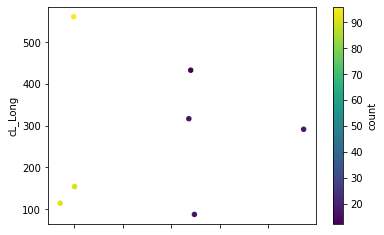

In [109]:
plot_bygroup_df.plot.scatter(x='cL_Lat',y='cL_Long',c='count',colormap='viridis')

In [119]:
plot_df[['cL_Lat', 'cL_Long']].dropna()

,cL_Lat,cL_Long
0,298.481481,561.222222
1,298.481481,561.222222
2,298.481481,561.222222
3,298.481481,561.222222
4,298.481481,561.222222
...,...,...
347,298.481481,561.222222
348,298.481481,561.222222
349,298.481481,561.222222
350,298.481481,561.222222


In [123]:
nonNAN_index = plot_df[['cL_Lat', 'cL_Long']].dropna().index

In [126]:
X = np.array(plot_df.iloc[nonNAN_index,:][['cL_Lat', 'cL_Long']] )

In [129]:
len(nonNAN_index)

340

In [130]:
X[60]

array([539.83333333, 433.16666667])

In [131]:
X.shape

(340, 2)

In [132]:
type(X[0,0])

numpy.float64

In [134]:
 np.isfinite(X).all()

True

In [135]:
X.shape

(340, 2)

In [145]:
int(np.ceil(X.shape[0]/50))

7

In [146]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(np.ceil(X.shape[0]/50)), random_state=0).fit(X)

In [140]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

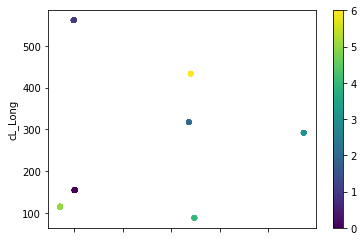

In [148]:
plot_df.iloc[nonNAN_index,:].plot.scatter(x='cL_Lat',y='cL_Long',c=kmeans.labels_,colormap='viridis')